In [2]:
from google.colab import drive
drive.mount('/content/drive')

%pip install keras-cv --quiet

import matplotlib.pyplot as plt
from pathlib import Path
from  tqdm import tqdm, trange
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
from time import perf_counter_ns, time_ns
from collections import defaultdict

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 54.5 MB/s eta 0:00:00


In [3]:
class PerfCounterCallback(tf.keras.callbacks.Callback):
  def __init__(self, latency_ref):
    super().__init__()
    self.latency_ref = latency_ref

  def on_predict_begin(self, logs=None):
    self.pred_start = perf_counter_ns()

  def on_predict_end(self, logs=None):
    self.pred_end = perf_counter_ns()
    elapsed = self.pred_end - self.pred_start
    self.latency_ref.append(elapsed)


class Coco2017Dataset:
  def __init__(self, img_dir: str, transform=None) -> None:
    assert (p := Path(img_dir)).exists() and p.is_dir(), f"Image directory {img_dir} does not exist"
    self.img_paths = [str(p) for p in Path(img_dir).glob("*.jpg")]
    self.transform = transform

  def __len__(self) -> int:
    return len(self.img_paths)

  def __getitem__(self, idx: int) -> tf.Tensor:
    img_path = self.img_paths[idx]
    with tf.device("/device:GPU:0"):
      image = tf.io.read_file(img_path)
      image = tf.image.decode_jpeg(image, channels=3)
      image = tf.cast(image, tf.float32) / 255
      image = tf.image.resize(image, (640, 640), antialias=True)
    return image

1737716908396532797


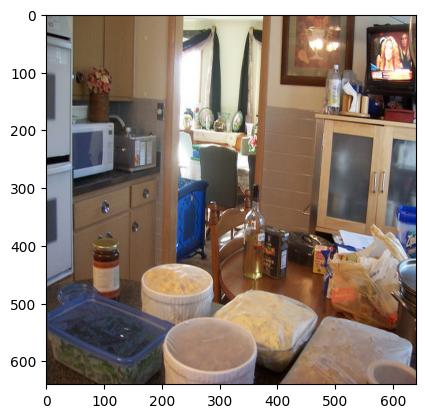

In [4]:
perf_callback = PerfCounterCallback(latency_ref=[])

coco_ds = Coco2017Dataset(img_dir="/content/drive/MyDrive/colab/datasets/coco2017_val")
plt.imshow(coco_ds[0])

timestamp = time_ns()
print(timestamp)
results_filepath = f'/content/drive/MyDrive/colab/results/tensorflow-yolo-{timestamp}.csv'
telemetry = defaultdict(list)

## YOLOv8 latency in Tensorflow

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_m_backbone_coco", load_weights=True)
model = keras_cv.models.YOLOV8Detector(num_classes=80, bounding_box_format="xyxy", backbone=backbone, fpn_depth=1)

# model.summary() output
# Total params: 25,935,744 (98.94 MB)
# Trainable params: 25,902,624 (98.81 MB)
# Non-trainable params: 33,120 (129.38 KB)

100%|██████████| 646/646 [00:00<00:00, 889kB/s]


100%|██████████| 45.6M/45.6M [00:01<00:00, 33.5MB/s]


In [ ]:
# 5k warmup
# for img in tqdm(coco_ds, desc="Warmup"):
#   with tf.device("/device:GPU:0"):
#     img = tf.expand_dims(img, axis=0)
#   assert "GPU" in img.device
#   _ = model.predict(img)
# with 5k images warmup not necessary on second thought

# latency benchmark
perf_callback.latency_ref.clear()
for i, img in enumerate(tqdm(coco_ds, desc="Benchmark"), start=1):
  with tf.device("/device:GPU:0"):
    img = tf.expand_dims(img, axis=0)
  assert "GPU" in img.device
  _ = model.predict(img, callbacks=[perf_callback], verbose=0)

  telemetry["framework"].append("TensorFlow")
  telemetry["model_name"].append("YOLOv8m")
  telemetry["phase"].append("latency")
  telemetry["epoch"].append(i)
  telemetry["loss"].append(-1)
  telemetry["performance"].append(-1)
telemetry["elapsed_time"].extend(perf_callback.latency_ref)
pd.DataFrame(telemetry).to_csv(results_filepath, index=False)

Benchmark: 100%|██████████| 5000/5000 [12:56<00:00,  6.44it/s]


## Warm up

In [ ]:
for _ in trange(12):
  backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_m_backbone_coco", load_weights=True)
  model = keras_cv.models.YOLOV8Detector(num_classes=80, bounding_box_format="xyxy", backbone=backbone, fpn_depth=1)
  perf_callback.latency_ref.clear()

  for i in range(1, 21):
    with tf.device("/device:GPU:0"):
      img = tf.expand_dims(coco_ds[i], axis=0)
    assert "GPU" in img.device
    _ = model.predict(img, callbacks=[perf_callback], verbose=0)

    telemetry["framework"].append("TensorFlow")
    telemetry["model_name"].append("YOLOv8m")
    telemetry["phase"].append("warmup")
    telemetry["epoch"].append(i)
    telemetry["loss"].append(-1)
    telemetry["performance"].append(-1)
  telemetry["elapsed_time"].extend(perf_callback.latency_ref)

pd.DataFrame(telemetry).to_csv(results_filepath, index=False)

100%|██████████| 12/12 [02:00<00:00, 10.03s/it]
